# single cell analysis

In [1]:
from utilities import *

18-Jul-25 14:23:03 - bfio.backends - WARNING  - Java backend is not available. This could be due to a missing dependency (jpype).


### downloading files from zenodo

https://zenodo.org/records/16037033

only the images necessary for image and picture analysis

In [ ]:
path_name = get_zenodo('example')

## images loading

### cell 

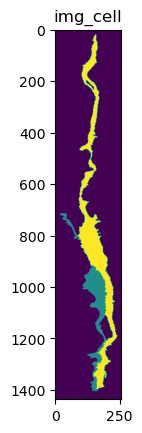

c:\Users\USUARIO\miniconda3\envs\MitoLandscape-env\Lib\site-packages\aicsimageio\readers\tiff_reader.py:148: UserWarning: Could not parse tiff pixel size: 'unit'
  warnings.warn(f"Could not parse tiff pixel size: {e}")


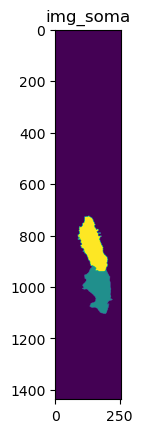

In [9]:
# getting the MITO.tif because contains pixel metadata information
img_mito, res = get_picture(path_name + '/example_MITO.tif')

# image contains 2 cell
img_cell = get_picture(path_name + '/example_CELLS.tif')[0]


info_cell = get_masks(img_cell)

# labels of the cells
cell_labels = info_cell[0]
# array with cell masks
cell_masks = info_cell[2]
show_pic(img_cell, 'img_cell')

img_soma = get_picture(path_name + '/example_SOMAS.tif')[0]
show_pic(img_soma, 'img_soma')

img_vent = get_picture(path_name + '/example_VENTRICLE.tif')[0]

### binarized mitochondria

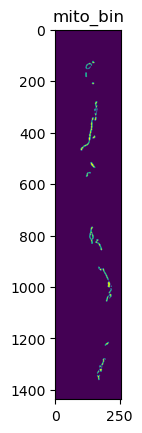

In [10]:
# let's focus only on the second cell
cell_label = cell_labels[1]
cell_mask = cell_masks[1]


# keeping only the soma corresponding to the second label
soma_mask = img_soma == cell_label


# we have the binary mitochondria saved in a file
mito_bin, _ = get_picture(path_name + '/example171_MITOBIN.tif')

mito_bin = apply_mask(mito_bin, cell_mask)
mito_bin = mito_bin.astype(bool)

show_pic(mito_bin, "mito_bin")

## distance maps calculation

### distance from ventricle

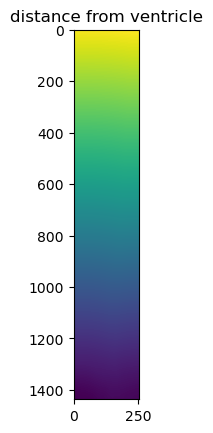

In [11]:
# using simple euclidean distance
vent_dist = distance_transform_edt(~img_vent, sampling= res)
show_pic(vent_dist, 'distance from ventricle')

### distance from soma within cell

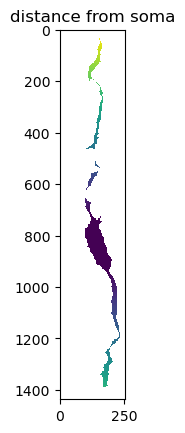

In [12]:
# calculating distance from the soma
soma_dist = geodesic_dist(cell_mask, soma_mask, res)
show_pic(soma_dist, 'distance from soma')

## compartment calculation

apical and basal soma and processes

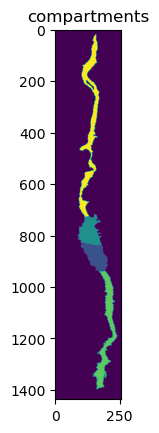

In [13]:
# annotating the compartments
# cell_dist is the distance of the soma from the ventricle
comp_labels, cell_dist = apical_progenitor_compartment_annotation(cell_mask, soma_mask, soma_dist, vent_dist)

# tifffile.imwrite(path_name +'/cell_compartment.tif', comp_labels)

show_pic(comp_labels, 'compartments')

## analysis

for other type of cells, you can use another compartment annotation instead of `comp_labels`

In [14]:
# cell analysis
cell_tables = cell_analysis(mito_bin, comp_labels, soma_dist, res)

# aggregated results on compartments
results_cell = cell_tables[0]
# mitochondria table
results_mito_cell = cell_tables[1]

print(results_cell)
print(results_mito_cell)


   compartment     volume  mito_volume     length  num_mito  num_p  num_r  \
0          1.0  11.221583     0.084851   0.000000       3.0    0.0    3.0   
1          2.0   8.763490     0.207458   0.000000       1.0    0.0    0.0   
2          3.0  10.693799     0.382723  17.484170      12.0    0.0   10.0   
3          4.0   8.169335     0.626744  26.579083      13.0    2.0    9.0   

   num_n  mito_length  
0    0.0     3.572449  
1    1.0     5.380667  
2    2.0    11.102215  
3    2.0    18.633127  
    mito_label  n_branches  n_junctions    length  soma_dist  compartment  \
0          0.0         1.0          0.0  0.237689  22.809464          4.0   
1          1.0         1.0          0.0  3.026124  21.953505          4.0   
2          2.0         1.0          0.0  0.751737  20.789345          4.0   
3          3.0         0.0          0.0  0.000000  19.431627          4.0   
4          4.0         3.0          1.0  1.757212  16.191369          4.0   
5          5.0         1.0     

### mitochondrial profile along processes

 - apical process: label 3
 - basal process: label 4

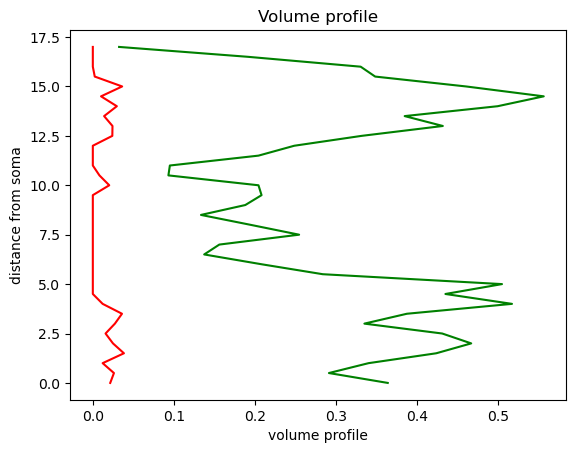

In [15]:
# analysis of the mitochondrial volume along the apical process
a_range, a_data, a_mito_data = process_analysis(comp_labels == 3, soma_dist, mito_bin, res)


plt.title('Volume profile')
plt.plot(a_data, a_range, label='cell', color='green')
plt.plot(a_mito_data, a_range, label='mito', color='red')
plt.xlabel("volume profile")
plt.ylabel("distance from soma")
plt.show()